Zillow Data

Improve existing algo

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
import tarfile
import zipfile
import tensorflow as tf
from six.moves import range
import collections
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

In [4]:
td = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

print("\nTrain data: head")
td.head()


Train data: head


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
prop_data = pd.read_csv("properties_2016.csv")
prop_data.head()

C:\Users\618586\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


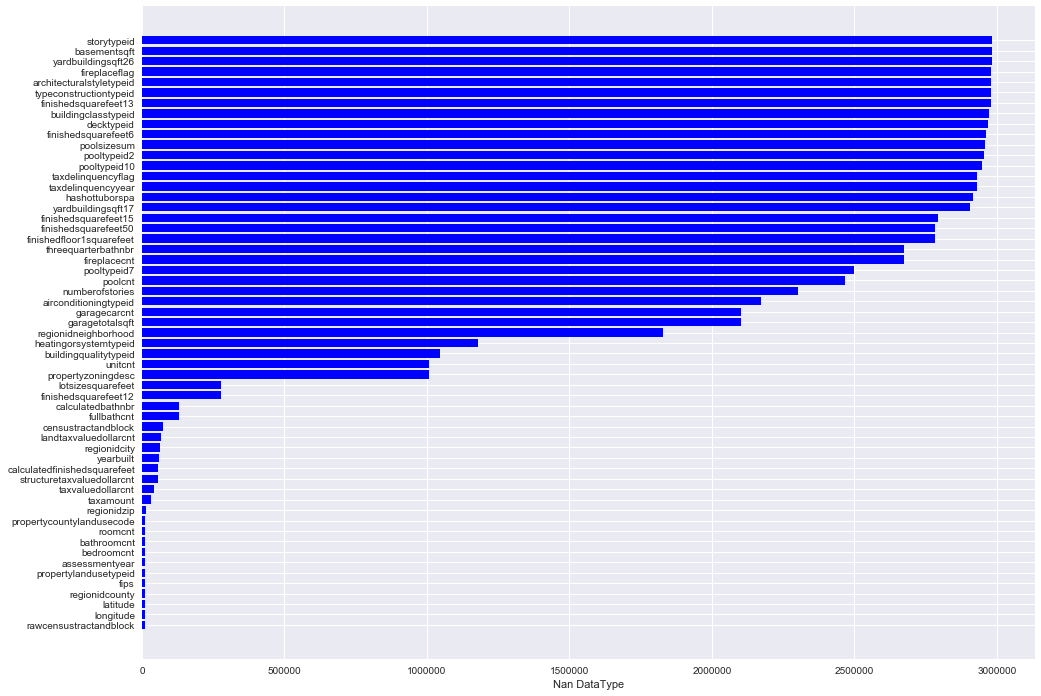

In [6]:
nan_dtype = prop_data.isnull().sum(axis=0).reset_index()
nan_dtype.columns = ['column_name','missing_count']
nan_dtype = nan_dtype.loc[nan_dtype['missing_count']>0]
nan_dtype = nan_dtype.sort_values(by='missing_count')

ind = np.arange(nan_dtype.shape[0])
fig, ax = plt.subplots(figsize=(16,12))
rects = ax.barh(ind, nan_dtype.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(nan_dtype.column_name.values, rotation='horizontal')
ax.set_xlabel('Nan DataType')
plt.show()

In [9]:
# taxamount, regionidzip, propertycountylandusecode, roomcnt, bathroomcnt, bedroomcnt, assessmentyear
#, propertylandusetypeid, fips, regionidcounty, latitude, longitude, rawcensustractandblock

# merge train data and prop data
train_data = pd.merge(td, prop_data, on='parcelid', how='left')
train_data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [10]:
pd.options.display.max_rows =65

dtype = train_data.dtypes.reset_index()
dtype.columns = ["Count","Column Type"]
dtype

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,airconditioningtypeid,float64
4,architecturalstyletypeid,float64
5,basementsqft,float64
6,bathroomcnt,float64
7,bedroomcnt,float64
8,buildingclasstypeid,float64
9,buildingqualitytypeid,float64


In [11]:
dtype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,53
2,datetime64[ns],1
3,object,5


In [17]:
missing_data = train_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['col_name','missing_count']
missing_data['missing_ratio'] = missing_data['missing_count'] / train_data.shape[0]
missing_data.loc[missing_data['missing_ratio']>0.999]

,col_name,missing_count,missing_ratio
5,basementsqft,90232,0.999524
8,buildingclasstypeid,90259,0.999823
15,finishedsquarefeet13,90242,0.999634
43,storytypeid,90232,0.999524
